In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import utilities3 #Researchers' own module

In [ ]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 1D problem such as the (time-independent) Burgers equation discussed in Section 5.1 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

from timeit import default_timer #timeit: 코드 실행 시간을 측정할 때 모듈
from utilities3 import *

# seed 번호 임의 고정
torch.manual_seed(0) #Sets the seed for generating random numbers. Returns a torch.Generator object.
np.random.seed(0)

In [ ]:
################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):  ##nn.Module?
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()
        #nn.Module의 init메서드에는 nn.Module클래스 내 함수로 접근하는 변수들이 존재함
        #정상적인 모듈을 만들기 위해서는 이러한 변수들을 상속 받아야 하기 때문에 
        #직접 만드는 모듈은 super().__init__()을 통해  변수들을 상속 받는다.

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.   
        """
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1
        #N: resolution
        #Fourier modes: 
        #When we do FFT we can get N modes at most. 
        #Since the mode is counted on both positive and negative sides, it's at most N/2. 

        self.scale = (1 / (in_channels*out_channels)) #스케일링 작업: 모든 특성의 범위(또는 분포)를 같게 만들어줌
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)
        ## einsum 연산은 Einstein Summation Convention에 따라 연산을 진행하는 방법
        ## Einstein Summation: 특정 index의 집합에 대한 합 연산(일반적인 ∑index set 연산)을 간결하게 표시하는 방법
        ## 행렬, 벡터의 내적(Dot products), 외적(Outer products), 전치(Transpose), 행렬곱 등을 일관성있게 표현 가능
        

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)
        ## fft: Computes the one dimensional discrete Fourier transform of input.
        ## rfft: Computes the one dimensional Fourier transform of real-valued input. 양의 주파수만 출력?
        # https://pytorch.org/docs/stable/generated/torch.fft.rfft.html#torch.fft.rfft

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        ## torch.zeros: 0으로 된 텐서
        ##torch.Tensor()의 기본 텐서 타입은 torch.FloatTensor. 이를 cfloat이라는 데이터 타입으로 따로 지정해줌
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1)) #rfft를 inverse

        return x

class MLP(nn.Module): ## 다층 퍼셉트론
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv1d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv1d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x) #relu가 아닌 gelu 사용
        x = self.mlp2(x)
        return x

class FNO1d(nn.Module): ## 가장 기초가 되는 클래스
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains **4 layers** of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 8 
        # pad the domain if input is non-periodic

        self.p = nn.Linear(2, self.width) # input channel_dim is 2: (u0(x), x)
        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.q = MLP(self.width, 1, self.width*2)  # output channel_dim is 1: u1(x)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.p(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = self.q(x)
        x = x.permute(0, 2, 1)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float) #np.linspace(0,1,size_x)는 0 ~ 1사이의 값을 size_x개로 등분한 값을 생성
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

In [ ]:
################################################################
#  configurations
################################################################
ntrain = 1000
ntest = 100

sub = 2**6 #subsampling rate. sub = 2**3과 큰 성능 차이를 보이지 않음
h = 2**13 // sub #total grid size divided by the subsampling rate #몫
s = h

batch_size = 20 #데이터를 20개씩 쪼개서 학습
learning_rate = 0.001
epochs = 500 #모든 데이터셋을 500번 학습
iterations = epochs*(ntrain//batch_size) # 500*1000/20=25000

modes = 16
width = 64

In [ ]:
import pandas as pd
from numpy import linalg 
import matplotlib.pyplot as plt

In [ ]:
################################################################
# read data
################################################################

# Data is of the shape (number of samples, grid size)
dataloader = MatReader('data/burgers_data_R10.mat')
x_data = dataloader.read_field('a')[:,::sub]
y_data = dataloader.read_field('u')[:,::sub]

x_data_T = x_data.T.numpy()
x_df = pd.DataFrame(x_data_T)
print('x_data: \n', x_df)

y_data_T = y_data.T.numpy()
y_df = pd.DataFrame(y_data_T)
print('y_data: \n', y_df)

x_data: 
          0         1         2         3         4         5         6     \
0    0.835411  0.474078 -0.380157 -0.446522  0.004025 -0.193616 -0.678259   
1    0.826709  0.464289 -0.420106 -0.417413  0.032214 -0.237041 -0.752601   
2    0.810748  0.462145 -0.456259 -0.367195  0.065874 -0.266417 -0.830862   
3    0.790824  0.463271 -0.478236 -0.299583  0.099902 -0.284518 -0.907159   
4    0.768692  0.464605 -0.482833 -0.225427  0.126992 -0.298697 -0.979663   
..        ...       ...       ...       ...       ...       ...       ...   
123  0.830258  0.621486 -0.365200 -0.422462 -0.136201  0.048714 -0.556643   
124  0.824852  0.592879 -0.355782 -0.437658 -0.093668  0.005489 -0.555536   
125  0.825201  0.559115 -0.342045 -0.449190 -0.061565 -0.037640 -0.558117   
126  0.830382  0.524272 -0.336852 -0.456680 -0.038053 -0.086320 -0.576348   
127  0.835664  0.494371 -0.349455 -0.457559 -0.018141 -0.140510 -0.616903   

         7         8         9     ...      2038      2039      2

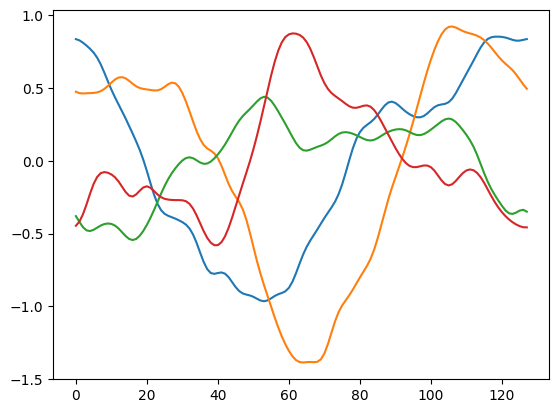

In [ ]:
# x_data 형태 미리보기
for i in range(4):
    graph = x_df[i].plot()

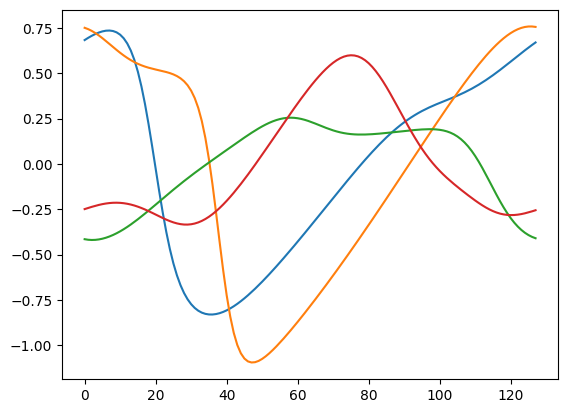

In [ ]:
# y_data 형태 미리보기
for i in range(4):
    graph = y_df[i].plot()

In [ ]:
x_train = x_data[:ntrain,:] # 앞 1000개
y_train = y_data[:ntrain,:] 
x_test = x_data[-ntest:,:] # 뒤 100개
y_test = y_data[-ntest:,:]

x_train = x_train.reshape(ntrain,s,1) #s = 2**10 = 1024
x_test = x_test.reshape(ntest,s,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

# model
model = FNO1d(modes, width).cuda()
print(count_params(model))

582849


In [ ]:
print(model)
print(model.parameters())

FNO1d(
  (p): Linear(in_features=2, out_features=64, bias=True)
  (conv0): SpectralConv1d()
  (conv1): SpectralConv1d()
  (conv2): SpectralConv1d()
  (conv3): SpectralConv1d()
  (mlp0): MLP(
    (mlp1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (mlp2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  )
  (mlp1): MLP(
    (mlp1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (mlp2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  )
  (mlp2): MLP(
    (mlp1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (mlp2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  )
  (mlp3): MLP(
    (mlp1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (mlp2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  )
  (w0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (q): MLP(
    (mlp1): Conv1d(64, 128, kernel_size=(1,), stride=(1,

In [ ]:
import matplotlib.pyplot as plt
df = pd.DataFrame(columns=['epochs', 't2-t1', 'train_MSE', 'train_l2', 'test_l2'])

In [ ]:
################################################################
# training and evaluation
################################################################
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  #weight_decay: 가중치 조정. 오버피팅 현상을 해소하기 위함
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iterations)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        scheduler.step()
        train_mse += mse.item()
        train_l2 += l2.item()
    #.eval() 함수: evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
    # https://bluehorn07.github.io/2021/02/27/model-eval-and-train.html
    model.eval() #https://coffeedjimmy.github.io/pytorch/2019/11/05/pytorch_nograd_vs_train_eval/
    test_l2 = 0.0
    #파이토치는 신경망 모델 속 변수들이 지나가는 길인 그래프를 생성함
    #but 평가과정에서는 기울기를 계산하기 않아도 됨
    #requires_grad=True인 텐서의 기록 중 아래의 코드블럭은 추적하지 못하게끔
    ## torch.no_grad() 함수로 감싸 autograd를 비활성화
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader) # train_mse = train_mse/len(train_loader) 랑 동일한 의미
    train_l2 /= ntrain
    test_l2 /= ntest
    
    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)
    df.loc[ep]=[ep, t2-t1, train_mse, train_l2, test_l2]

print(df)
    #epochs=500, t2-t1=각 에포크별 걸리는 시간, train_mse, train_l2: trainset에 대한 l2 norm값, test_l2trainset에 대한 l2 norm값

0 4.649566061999991 0.058980187657289206 0.3941147236824036 0.14635297298431396
1 0.7421255339999959 0.007650593038415536 0.1554464851617813 0.16817336797714233
2 0.7019996209999988 0.004444547410821542 0.12046795642375946 0.1246598219871521
3 0.837934735999994 0.0037645058240741492 0.11175042802095413 0.049169434905052184
4 0.7390585150000106 0.0030034132802393286 0.10049888980388641 0.05705528974533081
5 0.7317221950000032 0.0026862942351726813 0.09379923045635223 0.09693874716758728
6 0.5445462840000062 0.0024392938989331015 0.08976956456899643 0.040188644528388974
7 0.5210254790000022 0.00195317989011528 0.08464063835144044 0.047086299657821656
8 0.5342303179999988 0.001920945744495839 0.07902101337909699 0.09275008678436279
9 0.5272199899999919 0.0017485494454740546 0.07867224508523941 0.04617760956287384
10 0.521897666000001 0.0016971491341246292 0.07455795776844025 0.04396576464176178
11 0.5251616509999906 0.00157458838832099 0.07245696175098419 0.04135043323040009
12 0.52295699

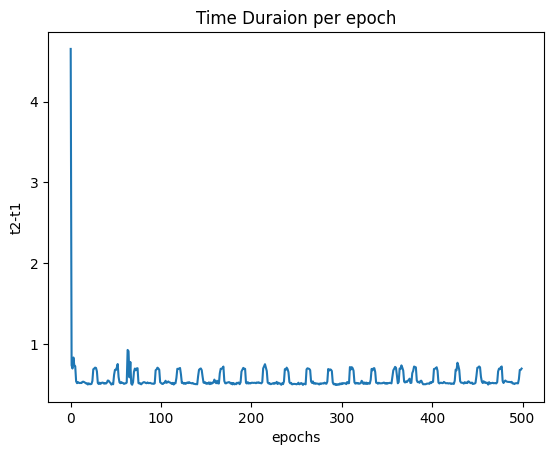

In [ ]:
df['t2-t1'].plot()
plt.title("Time Duraion per epoch")
plt.xlabel("epochs")
plt.ylabel('t2-t1')
plt.show()

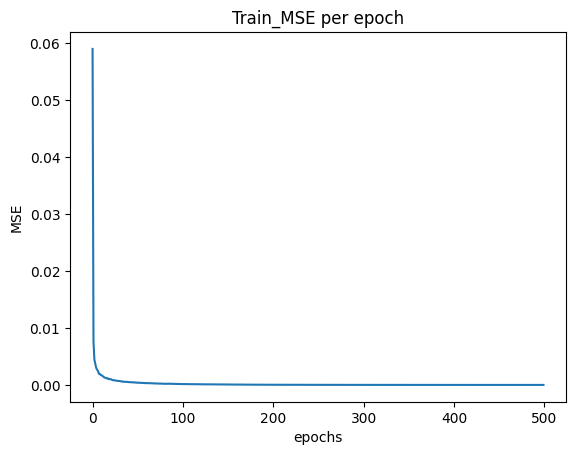

In [ ]:
df['train_MSE'].plot()
plt.title("Train_MSE per epoch")
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.show()

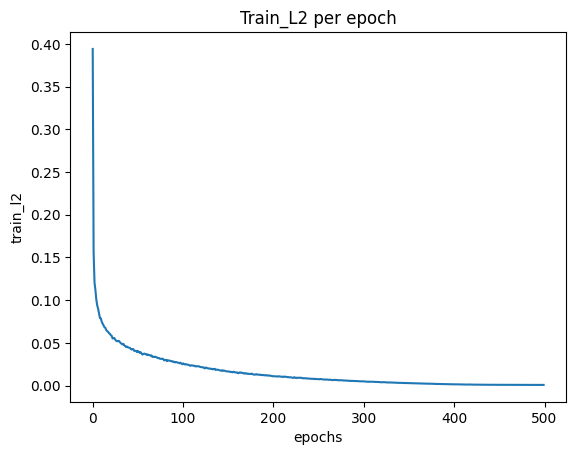

In [ ]:
df['train_l2'].plot()
plt.title("Train_L2 per epoch")
plt.xlabel("epochs")
plt.ylabel("train_l2")
plt.show()

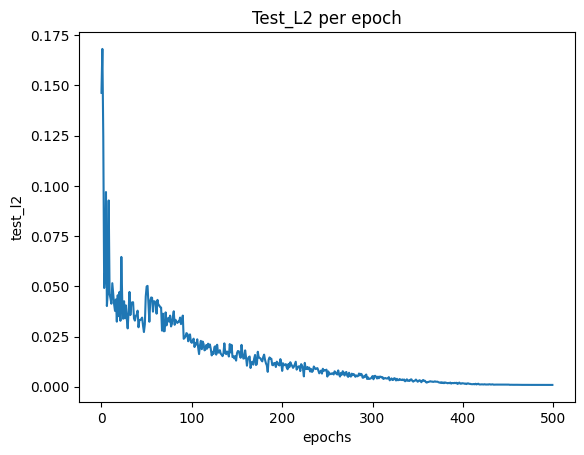

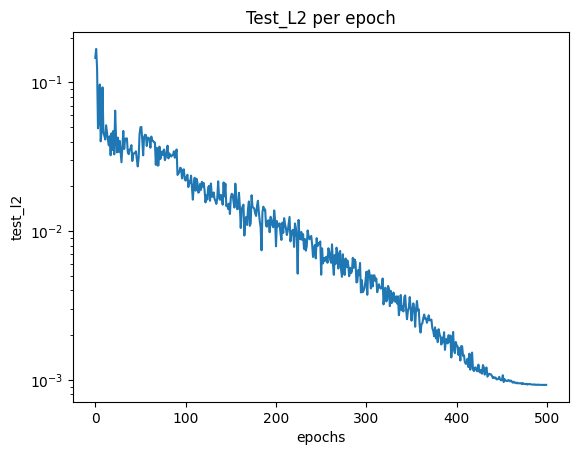

In [ ]:
df['test_l2'].plot()
plt.title("Test_L2 per epoch")
plt.xlabel("epochs")
plt.ylabel("test_l2")
plt.show()

plt.plot(range(len(df['test_l2'])), df['test_l2'])
plt.title("Test_L2 per epoch")
plt.xlabel("epochs")
plt.ylabel("test_l2")
plt.yscale('log', base=10)
plt.show()

In [20]:
# torch.save(model, './ns_fourier_burgers_8192')

pred = torch.zeros(y_test.shape)
real = torch.zeros(y_test.shape)

index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x).view(-1)
        pred[index] = out
        real[index] = y
        print('pred', out.view(1, -1))
        print('y   ', y.view(1, -1))
        
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        # print(index, test_l2)
        index = index + 1

# scipy.io.savemat('./burger_test.mat', mdict={'pred': pred.cpu().numpy()})

pred tensor([[ 0.1209,  0.1405,  0.1596,  0.1782,  0.1962,  0.2135,  0.2300,  0.2455,
          0.2600,  0.2732,  0.2849,  0.2950,  0.3034,  0.3099,  0.3144,  0.3168,
          0.3169,  0.3147,  0.3101,  0.3030,  0.2937,  0.2823,  0.2691,  0.2545,
          0.2388,  0.2225,  0.2062,  0.1903,  0.1753,  0.1613,  0.1490,  0.1384,
          0.1299,  0.1234,  0.1189,  0.1163,  0.1156,  0.1166,  0.1193,  0.1234,
          0.1289,  0.1353,  0.1427,  0.1507,  0.1593,  0.1681,  0.1771,  0.1860,
          0.1946,  0.2027,  0.2102,  0.2167,  0.2221,  0.2261,  0.2285,  0.2294,
          0.2284,  0.2253,  0.2201,  0.2125,  0.2027,  0.1905,  0.1761,  0.1596,
          0.1409,  0.1203,  0.0980,  0.0740,  0.0485,  0.0218, -0.0061, -0.0348,
         -0.0641, -0.0938, -0.1236, -0.1533, -0.1824, -0.2108, -0.2381, -0.2641,
         -0.2884, -0.3109, -0.3314, -0.3499, -0.3664, -0.3807, -0.3931, -0.4034,
         -0.4117, -0.4180, -0.4225, -0.4253, -0.4264, -0.4261, -0.4242, -0.4208,
         -0.4157, -0.40

In [21]:
print(pred.shape)
print(real.shape)

torch.Size([100, 128])
torch.Size([100, 128])


torch.Size([1, 128, 1])


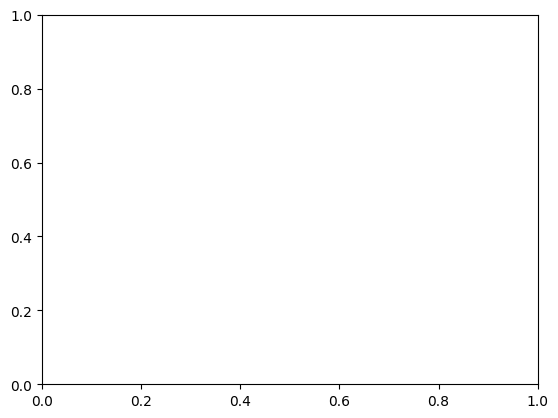

In [35]:
################################################################
# Visualization
################################################################

import matplotlib.animation as animation
from IPython.display import HTML

# 데이터프레임 생성
a = dataloader.read_field('a')[0,::sub] #예시로 0행을 u0로 둠. 다른 행을 u0로 두고 싶은 경우 행 숫자 변경하면 됨!
a = a.cuda()
a = a.view(1,-1,1)
print(a.shape)

df = pd.DataFrame(columns=range(s))

for i in range(0,20):
    out = model(a)
    a = out
    pred = a.view(-1).tolist()
    df.loc[i] = pred

# Figure와 Axes 객체 생성
fig, ax = plt.subplots()

# 초기화 함수
def init():
    ax.clear()

# 애니메이션 업데이트 함수
def update(frame):
    ax.clear()
    
    # 현재 프레임에 해당하는 행 선택
    row = df.iloc[frame]
    
    # 플롯 생성
    x = np.linspace(0, 1, s)  # x축 값 생성
    y = row.values  # 현재 행의 y값
    ax.plot(x, y, 'r-')
    ax.set_xlim(0, 1)
    ax.set_ylim(-2, 2)
    ax.set_title(f'Time {frame}')
    
# 애니메이션 생성
ani = animation.FuncAnimation(fig, update, frames=len(df), interval=500, init_func=init) # 더 빠르게 animation 돌리고 싶으면 interval 줄이기 

HTML(ani.to_html5_video())

# 애니메이션 실행
# plt.show()